# [Dacon] 항공지연예측 - 파생변수

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# ----------------- 학습 ----------------------
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# ----------------- 모델 ----------------------
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.linear_model import Ridge,Lasso

from lightgbm import LGBMRegressor,LGBMClassifier

# ----------------- 평가 ----------------------
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve

# Data Load

<pre>
Month: 해당 항공편의 출발 월입니다. 1부터 12까지의 값을 가집니다.
Day_of_Month: 해당 항공편의 출발 날짜입니다. 1부터 31까지의 값을 가집니다.
Estimated_Departure_Time: 해당 항공편의 출발 예정 시간입니다. 시간은 24시간 형식으로 기록됩니다. (HH:MM)
Estimated_Arrival_Time: 해당 항공편의 도착 예정 시간입니다. 시간은 24시간 형식으로 기록됩니다. (HH:MM)
Cancelled: 해당 항공편이 취소되었는지 여부를 나타냅니다. Train, Test 데이터 모두 0 값만 존재합니다.
Diverted: 해당 항공편이 경유지를 변경하여 다른 공항으로 이동되었는지 여부를 나타냅니다. Train, Test 데이터 모두 0 값만 존재합니다.
Origin_Airport: 해당 항공편의 출발 공항의 IATA 코드입니다.
Origin_Airport_ID: 해당 항공편의 출발 공항의 고유 ID입니다.
Origin_State: 해당 항공편의 출발 공항이 위치한 주(State) 이름입니다.
Destination_Airport: 해당 항공편의 도착 공항의 IATA 코드입니다.
Destination_Airport_ID: 해당 항공편의 도착 공항의 고유 ID입니다.
Destination_State: 해당 항공편의 도착 공항이 위치한 주(State) 이름입니다.
Distance: 해당 항공편의 비행 거리입니다. 확인해보니 마일(mile) 단위로 기록됩니다.
Airline: 해당 항공편을 운항하는 항공사 이름입니다.
Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 IATA 코드입니다.  (IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 식별번호입니다. 
Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호입니다.

In [3]:
train=pd.read_csv('train_2.csv')
test=pd.read_csv('test_2.csv')
submit=pd.read_csv('sample_submission.csv')

In [4]:
test.head(1)

,Unnamed: 0,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Destination_Airport,Destination_Airport_ID,Distance,Airline,Tail_Number,Distance(km),Estimated_Departure_Time_hour,Estimated_Departure_Time_min,Estimated_Arrival_Time_hour,Estimated_Arrival_Time_min,Duration_of_Time_hour,Duration_of_Time_min,Duration_of_Time
0,0,12,16,11.56,11.589279,IAH,12266,SAT,14683,191.0,United Air Lines Inc.,N79402,307.38394,11.0,56.0,11.0,58.927934,0.0,0.048799,0.048799


In [5]:
train=train.drop('Unnamed: 0',axis=1)
test=test.drop('Unnamed: 0',axis=1)

# 분석

## Tail_Number  --> drop
- 항공사마다 일정한 Tail_Number가 부여되지 않음

In [6]:
train[['Airline','Tail_Number']].value_counts()

Airline                 Tail_Number
Hawaiian Airlines Inc.  N483HA         530
                        N487HA         525
                        N488HA         518
                        N495HA         497
                        N476HA         489
                                      ... 
American Airlines Inc.  N727AN           1
                        N840AN           1
Horizon Air             N642qx           1
Delta Air Lines Inc.    N816NW           1
                        N852NW           1
Length: 6604, dtype: int64

In [7]:
train['Airline'].unique()

array(['Southwest Airlines Co.', 'SkyWest Airlines Inc.',
       'American Airlines Inc.', 'United Air Lines Inc.',
       'Republic Airlines', 'ExpressJet Airlines Inc.',
       'Delta Air Lines Inc.', 'Air Wisconsin Airlines Corp',
       'Horizon Air', 'JetBlue Airways', 'Spirit Air Lines',
       'Alaska Airlines Inc.', 'Mesa Airlines Inc.',
       'Frontier Airlines Inc.', 'Trans States Airlines',
       'Endeavor Air Inc.', 'Comair Inc.', 'Capital Cargo International',
       'Envoy Air', 'Hawaiian Airlines Inc.', 'Allegiant Air',
       'Virgin America', 'Peninsula Airways Inc.', 'Compass Airlines',
       'GoJet Airlines, LLC d/b/a United Express',
       'Commutair Aka Champlain Enterprises, Inc.',
       'Empire Airlines Inc.', 'Cape Air'], dtype=object)

In [8]:
train['Airline'][train['Tail_Number']=='N7858A'].unique()

array(['Southwest Airlines Co.'], dtype=object)

In [9]:
# train['Tail_Number'][train['Airline']=='SkyWest Airlines Inc.'].unique()

# 불필요 타겟 삭제

In [10]:
print(train['Origin_Airport'].nunique(),train['Origin_Airport_ID'].nunique())
print(train['Destination_Airport'].nunique(),train['Destination_Airport_ID'].nunique())

374 374
375 375


In [11]:
train=train.drop('Origin_Airport',axis=1)
test=test.drop('Origin_Airport',axis=1)

train=train.drop('Destination_Airport',axis=1)
test=test.drop('Destination_Airport',axis=1)

train=train.drop('Distance(km)',axis=1)
test=test.drop('Distance(km)',axis=1)

In [12]:
train=train.drop('Tail_Number',axis=1)
test=test.drop('Tail_Number',axis=1)

In [13]:
train=train.drop('Estimated_Arrival_Time_min',axis=1)
test=test.drop('Estimated_Arrival_Time_min',axis=1)

train=train.drop('Estimated_Departure_Time_min',axis=1)
test=test.drop('Estimated_Departure_Time_min',axis=1)

train=train.drop('Duration_of_Time_min',axis=1)
test=test.drop('Duration_of_Time_min',axis=1)

In [14]:
train.columns, test.columns

(Index(['Month', 'Day_of_Month', 'Estimated_Departure_Time',
        'Estimated_Arrival_Time', 'Origin_Airport_ID', 'Destination_Airport_ID',
        'Distance', 'Airline', 'Delay', 'Estimated_Departure_Time_hour',
        'Estimated_Arrival_Time_hour', 'Duration_of_Time_hour',
        'Duration_of_Time'],
       dtype='object'),
 Index(['Month', 'Day_of_Month', 'Estimated_Departure_Time',
        'Estimated_Arrival_Time', 'Origin_Airport_ID', 'Destination_Airport_ID',
        'Distance', 'Airline', 'Estimated_Departure_Time_hour',
        'Estimated_Arrival_Time_hour', 'Duration_of_Time_hour',
        'Duration_of_Time'],
       dtype='object'))

# object 처리

In [15]:
train.select_dtypes('object').columns, test.select_dtypes('object').columns

(Index(['Airline', 'Delay'], dtype='object'),
 Index(['Airline'], dtype='object'))

In [16]:
train['Delay'].value_counts()

Not_Delayed    210001
Delayed         45000
Name: Delay, dtype: int64

In [17]:
train['Delay']=train['Delay'].replace(['Not_Delayed','Delayed',np.nan],[0,1,3])
train['Delay'].value_counts()

3.0    744999
0.0    210001
1.0     45000
Name: Delay, dtype: int64

In [18]:
train['Delay']=train['Delay'].astype('int')
train['Delay'].value_counts()

3    744999
0    210001
1     45000
Name: Delay, dtype: int64

In [19]:
print(train.isna().sum())
print(test.isna().sum())

Month                            0
Day_of_Month                     0
Estimated_Departure_Time         0
Estimated_Arrival_Time           0
Origin_Airport_ID                0
Destination_Airport_ID           0
Distance                         0
Airline                          0
Delay                            0
Estimated_Departure_Time_hour    0
Estimated_Arrival_Time_hour      0
Duration_of_Time_hour            0
Duration_of_Time                 0
dtype: int64
Month                            0
Day_of_Month                     0
Estimated_Departure_Time         0
Estimated_Arrival_Time           0
Origin_Airport_ID                0
Destination_Airport_ID           0
Distance                         0
Airline                          0
Estimated_Departure_Time_hour    0
Estimated_Arrival_Time_hour      0
Duration_of_Time_hour            0
Duration_of_Time                 0
dtype: int64


In [20]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(train['Airline'])
train['Airline']=le.transform(train['Airline'])
test['Airline']=le.transform(test['Airline'])

In [21]:
test['Airline'].value_counts().sort_index()

0      14106
1      32442
2      15767
3      98559
4        111
5      10740
6      29631
7       8582
8       9166
9      96953
10      1143
11     25935
12     32173
13     22588
14     21388
15      9994
16     10795
17     13207
18     49311
19     27656
20       210
21     37099
22     96776
23    201905
24     28551
25     10705
26     93080
27      1427
Name: Airline, dtype: int64

In [22]:
train=pd.get_dummies(train)
test=pd.get_dummies(test)

In [23]:
# columns_dic = {'Airline_Air Wisconsin Airlines Corp':'Airline_1',
#           'Airline_Alaska Airlines Inc.':'Airline_2',
#           'Airline_Allegiant Air':'Airline_3',
#           'Airline_American Airlines Inc.':'Airline_4',
#           'Airline_Cape Air':'Airline_5',
#             'Airline_Capital Cargo International':'Airline_5', 
#            'Airline_Comair Inc.':'Airline_6',
#        'Airline_Commutair Aka Champlain Enterprises, Inc.':'Airline_7',
#        'Airline_Compass Airlines':'Airline_8', 
#            'Airline_Delta Air Lines Inc.':'Airline_9',
#        'Airline_Empire Airlines Inc.':'Airline_10', 
#            'Airline_Endeavor Air Inc.':'Airline_11',
#        'Airline_Envoy Air':'Airline_12', 
#            'Airline_ExpressJet Airlines Inc.':'Airline_13',
#        'Airline_Frontier Airlines Inc':'Airline_14' ,
#            'Airline_GoJet Airlines':'Airline_15',
#        'Airline_Hawaiian Airlines Inc.':'Airline_16', 
#            'Airline_Horizon Air':'Airline_17',
#        'Airline_JetBlue Airways':'Airline_18', 
#            'Airline_Mesa Airlines Inc.':'Airline_19',
#        'Airline_Peninsula Airways Inc.':'Airline_20', 
#            'Airline_Republic Airlines':'Airline_21',
#        'Airline_SkyWest Airlines Inc.':'Airline_22', 
#            'Airline_Southwest Airlines Co.':'Airline_23',
#        'Airline_Spirit Air Lines':'Airline_24', 
#            'Airline_Trans States Airlines':'Airline_25',
#        'Airline_United Air Lines Inc.':'Airline_26',
#            'Airline_Virgin America':'Airline_27'}

In [24]:
# train.rename(columns=,inplace=True)
# train.columns

In [25]:
# test.rename(columns_dic,inplace=True)
# test.columns

# Target 결측 채우기

In [26]:
target  = train['Delay']
df = train.drop(['Delay'], axis=1)

df1   = train[train['Delay']!=3]
y_df1 = df1['Delay']
X_df1 = df1.drop('Delay', axis=1)

rf = LGBMClassifier(random_state=11)  #RandomForestRegressor(random_state=11)
X_train, X_test, y_train, y_test = train_test_split(X_df1, y_df1, test_size=0.2, random_state=11)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
mse_score = mean_squared_error(y_test, pred)
print("RMSE : ", np.sqrt(mse_score) )

df0 = train[train['Delay'] == 3]
y_df0 = df0['Delay']
X_df0 = df0.drop('Delay', axis=1)
pred2 = rf.predict(X_df0)
print(pred2)
widx = X_df0.index.values

RMSE :  0.41860704508985375
[0 0 0 ... 0 0 0]


In [27]:
train['Delay'].loc[widx] = pred2
train['Delay'].value_counts()

0    952801
1     47199
Name: Delay, dtype: int64

# 다중공선 제거

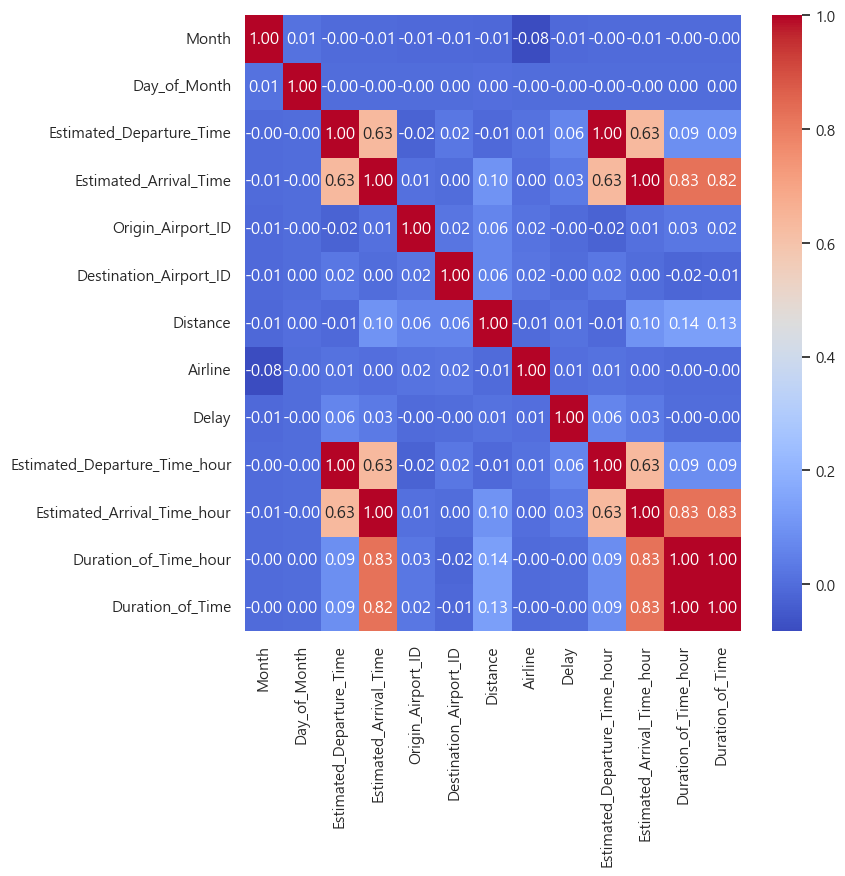

In [28]:
plt.figure(figsize=(8, 8))
sns.heatmap(train.corr(), fmt='.2f',annot=True,cmap='coolwarm')
plt.show()

In [29]:
y=train['Delay']
X=train.drop('Delay',axis=1)

rf = LGBMClassifier(random_state=11)  #RandomForestRegressor(random_state=11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
rf.fit(X_train, y_train)

pred = rf.predict_proba(X_test)
pred
# mse_score = mean_squared_error(y_test, pred)
# print("RMSE : ", np.sqrt(mse_score) )

array([[0.96073299, 0.03926701],
       [0.91960977, 0.08039023],
       [0.91973133, 0.08026867],
       ...,
       [0.97781227, 0.02218773],
       [0.96728417, 0.03271583],
       [0.97204282, 0.02795718]])

[333 367 356 277 357 340 352 335  37  32   2 212]


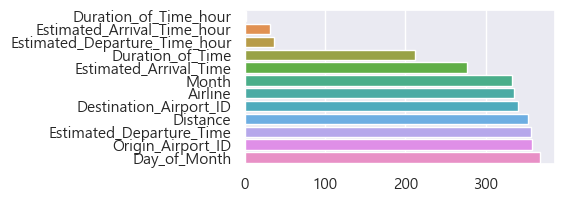

In [30]:
print( rf.feature_importances_ ) # fit 후 모델이 어떤 피쳐를 중심으로 학습했는지 알려줌
plt.figure(figsize=(4,2))
s = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values()
sns.barplot(x=s.values, y=s.index)
plt.show()

In [31]:
test_pred = rf.predict_proba(test)

In [32]:
submit.head()

,ID,Not_Delayed,Delayed
0,TEST_000000,0,1
1,TEST_000001,0,1
2,TEST_000002,0,1
3,TEST_000003,0,1
4,TEST_000004,0,1


In [33]:
# submit=submit.drop('ID',axis=1)

In [34]:
submit[['Not_Delayed','Delayed']]=test_pred
submit.head()

,ID,Not_Delayed,Delayed
0,TEST_000000,0.963373,0.036627
1,TEST_000001,0.959397,0.040603
2,TEST_000002,0.940301,0.059699
3,TEST_000003,0.927225,0.072775
4,TEST_000004,0.875359,0.124641


In [35]:
submit.to_csv('./submit1.csv',index=False)